In [1]:
# changing core directory
import os
import sys

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if dir1 not in sys.path:
    sys.path.append(dir1)
os.chdir('..')

In [2]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# from src.attacks import fgsm_attack, only_disc_attack
# from src.attacks.utils import calculate_metrics_class_and_hiddens, req_grad
from src.config import get_disc_list
from src.data import MyDataset, load_data, transform_data
from src.models.LSTM import LSTM
# from src.utils import load_disc_model

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [3]:
from hydra import compose, initialize
from omegaconf import OmegaConf
initialize(config_path='../config/my_configs', version_base=None)
cfg = compose(config_name='attack_run_config.yaml')
print(OmegaConf.to_yaml(cfg))

attack_model:
  name: LSTM
  params:
    hidden_dim: 50
    n_layers: 1
    output_dim: 1
    dropout: 0.0
  hyperparameters_vary:
    dropout:
      optuna_type: float
      low: 0.1
      high: 0.7
      step: 0.1
  attack_train_mode: true
disc_model_reg:
  name: LSTM
  params:
    hidden_dim: 50
    n_layers: 1
    output_dim: 1
    dropout: 0.0
  hyperparameters_vary:
    dropout:
      optuna_type: float
      low: 0.1
      high: 0.7
      step: 0.1
  attack_train_mode: true
disc_model_check:
  name: LSTM
  params:
    hidden_dim: 50
    n_layers: 1
    output_dim: 1
    dropout: 0.0
  hyperparameters_vary:
    dropout:
      optuna_type: float
      low: 0.1
      high: 0.7
      step: 0.1
  attack_train_mode: true
attack:
  name: FGSMAttack
  short_name: fgsm_attack
  attack_params:
    eps:
    - 0.03
    n_steps: 10
  hyperparameters_vary:
    eps:
      optuna_type: float
      low: 0.01
      high: 0.5
      log: true
    n_steps:
      optuna_type: const
      value: 50
de

# NEW CODE

In [4]:
import os
import warnings

import hydra
import pandas as pd
import torch
from omegaconf import DictConfig
from torch.utils.data import DataLoader

from src.config import get_attack, get_criterion, get_disc_list, get_model
from src.data import MyDataset, load_data, transform_data
from src.estimation.estimators import AttackEstimator
from src.utils import save_experiment

In [5]:
X_train, y_train, X_test, y_test = load_data(cfg['dataset'])
X_train, X_test, y_train, y_test = transform_data(X_train, X_test, y_train, y_test, slice_data=cfg['slice'])

test_loader = DataLoader(
    MyDataset(X_test, y_test), 
    batch_size=cfg['batch_size'] , 
    shuffle=True
    )


device = torch.device(cfg["cuda"] if torch.cuda.is_available() else "cpu")

attack_model_path = os.path.join(
    cfg["model_folder"],
    cfg["attack_model"]["name"],
    f"model_{cfg['model_id_attack']}_{cfg['dataset']}.pt",
)

attack_model = get_model(
    cfg["attack_model"]["name"],
    cfg["attack_model"]["params"],
    path=attack_model_path,
    device=device,
    train_mode=cfg["attack_model"]["attack_train_mode"],
)

In [6]:
criterion = get_criterion(cfg["criterion_name"], cfg["criterion_params"])

disc_check_list = (
    get_disc_list(
        model_name=cfg["disc_model_check"]["name"],
        model_params=cfg["disc_model_check"]["params"],
        list_disc_params=cfg["list_check_model_params"],
        device=device,
        path=cfg["disc_path"],
        train_mode=False,
    )
    if cfg["use_disc_check"]
    else None
)
estimator = AttackEstimator(disc_check_list, cfg["metric_effect"])

In [7]:
alpha = 1
eps = 0.03

In [8]:
attack_metrics = pd.DataFrame()
attack_params = dict(cfg["attack"]["attack_params"])
attack_params["model"] = attack_model
attack_params["criterion"] = criterion
attack_params["estimator"] = estimator
attack_params["alpha"] = alpha
attack_params["eps"] = eps

if "list_reg_model_params" in cfg["attack"]:
    attack_params["disc_models"] = get_disc_list(
        model_name=cfg["disc_model_reg"]["name"],
        model_params=cfg["disc_model_reg"]["params"],
        list_disc_params=cfg["attack"]["list_reg_model_params"],
        device=device,
        path=cfg["disc_path"],
        train_mode=cfg["disc_model_reg"]["attack_train_mode"],
    )

attack = get_attack(cfg["attack"]["name"], attack_params)
X_adv = attack.apply_attack(test_loader).squeeze(-1)

results = attack.get_metrics()
results["eps"] = eps
attack_metrics = pd.concat([attack_metrics, results])

logging


  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
X_orig = torch.tensor(test_loader.dataset.X)

assert X_orig.shape == X_adv.shape

dataset_class = test_loader.dataset.__class__
dataset = dataset_class(X_adv, test_loader.dataset.y)

loader = DataLoader(dataset, batch_size=test_loader.batch_size, shuffle=True)

In [10]:
attack_params = dict(cfg["defence"]["attack_params"])
attack_params["model"] = attack_model
attack_params["criterion"] = criterion
attack_params["estimator"] = estimator
attack_params["alpha"] = alpha
attack_params["eps"] = eps

if "list_reg_model_params" in cfg["defence"]:
    attack_params["disc_models"] = get_disc_list(
        model_name=cfg["disc_model_reg"]["name"],
        model_params=cfg["disc_model_reg"]["params"],
        list_disc_params=cfg["defence"]["list_reg_model_params"],
        device=device,
        path=cfg["disc_path"],
        train_mode=cfg["disc_model_reg"]["attack_train_mode"],
    )

attack = get_attack(cfg["defence"]["name"], attack_params)
X_adv = attack.apply_attack(test_loader)

results = attack.get_metrics()
results["eps"] = eps
attack_metrics = pd.concat([attack_metrics, results])

logging


  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
attack

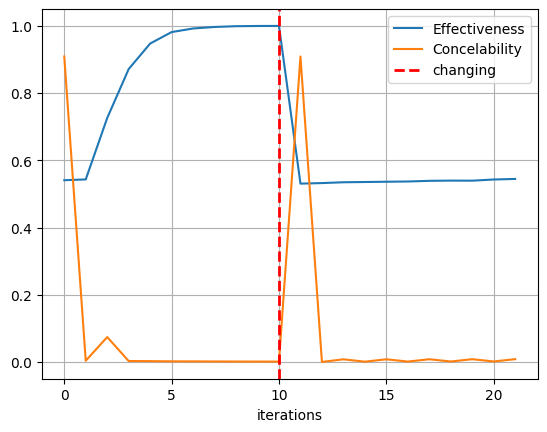

In [12]:
x = np.arange(len(attack_metrics))
plt.plot(x, attack_metrics['EFF'], label='Effectiveness')
plt.plot(x, attack_metrics['CONC'], label='Concelability')
plt.axvline(10, label='changing', c='red', linestyle='--', linewidth=2)
plt.legend()
plt.xlabel('iterations')
plt.grid()
plt.show()

In [13]:
attack_metrics.columns

Index(['ACC', 'ROC', 'PR', 'F1', 'EFF', 'L1', 'ACC_ORIG_ADV', 'HID', 'CONC',
       'F_EFF_CONC', 'step_id', 'eps'],
      dtype='object')

In [14]:
attack_metrics[['ACC', 'HID', 'step_id']]

,ACC,HID,step_id
0,0.4925,0.09119573,0
0,0.504015,0.99616027,1
0,0.345455,0.9256919,2
0,0.229167,0.9969394,3
0,0.156742,0.9972377,4
0,0.114318,0.99788207,5
0,0.088864,0.99804646,6
0,0.0725,0.9982598,7
0,0.058712,0.9984075,8
0,0.049924,0.9985432,9


# OLD CODE

In [15]:
dataset = 'FordA'

cfg = {
    'slice': True,
    'dataset': dataset,
    'batch_size': 256,
    'cuda': 'cuda:1',
    'train_mode': True,
    'model_folder': f'checkpoints/{dataset}/LSTM/',
    "model_id_attack": 0,
    "model_id": 1,
    "disc_check_params":{
        'model_id' : 0,
        'model_name':"fgsm_attack_eps=0.03_nsteps=10",
    },

    'list_reg_model_params': [{
        'model_id' : 0,
        'model_name':"fgsm_attack_eps=0.03_nsteps=10",
    }],

    # 'list_reg_model_params': [
    #     {'model_id' : 0, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=1_nsteps=10',},
    #     {'model_id' : 0, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=10_nsteps=10',},
    #     {'model_id' : 1, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=1_nsteps=10',},
    #     {'model_id' : 1, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=10_nsteps=10',},
    #     {'model_id' : 2, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=1_nsteps=10',},
    # ],
    "disc_path": "results/FordA/LSTM/discriminator/fgsm_attack_SAVE_TEST",
    'use_extra_sigmoid': False,
}

alpha = 0.001
criterion = torch.nn.BCELoss()

In [16]:
X_train, y_train, X_test, y_test = load_data(cfg['dataset'])
X_train, X_test, y_train, y_test = transform_data(X_train, X_test, y_train, y_test, slice_data=cfg['slice'])

test_loader = DataLoader(
    MyDataset(X_test, y_test), 
    batch_size=cfg['batch_size'] , 
    shuffle=True
    )

device= torch.device(cfg['cuda'] if torch.cuda.is_available() else 'cpu')

model = LSTM(
    hidden_dim = 50,
    n_layers = 1,
    output_dim = 1,
    dropout = 0.0,
).to(device)

model_path = cfg['model_folder'] + f'model_{cfg["model_id_attack"]}_{cfg["dataset"]}.pth'
model.load_state_dict(copy.deepcopy(torch.load(model_path)))

model.train(cfg['train_mode'])

LSTM(
  (rnn): LSTM(1, 50, batch_first=True)
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (final_activation): Sigmoid()
)

In [17]:
disc_model_check = LSTM(
    hidden_dim = 50,
    n_layers = 1,
    output_dim = 1,
    dropout = 0.0,
).to(device)

model_name = "fgsm_attack_eps=0.03_nsteps=10"
path = f"results/{dataset}/LSTM/discriminator/fgsm_attack"
disc_path = f"{path}/{model_name}/0.pt"
disc_model_check.load_state_dict(torch.load(disc_path))
disc_model_check.train(cfg['train_mode'])


disc_model = LSTM(
    hidden_dim = 50,
    n_layers = 1,
    output_dim = 1,
    dropout = 0.0,
)

In [18]:
disc_model_check

LSTM(
  (rnn): LSTM(1, 50, batch_first=True)
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (final_activation): Sigmoid()
)

In [ ]:
x, y = next(iter(test_loader))
x = x.to(device)

disc_model_check(x)[:10]

tensor([[1.4741e-04],
        [4.4087e-05],
        [2.0915e-04],
        [3.2020e-04],
        [2.9881e-04],
        [7.0435e-05],
        [8.9056e-05],
        [2.8993e-04],
        [3.2768e-04],
        [6.9433e-05]], device='cuda:1', grad_fn=<SliceBackward0>)

tensor([[1.6639e-04],
        [1.8285e-04],
        [1.2278e-04],
        [3.1654e-04],
        [1.0844e-04],
        [2.4435e-04],
        [5.5450e-05],
        [7.5110e-05],
        [1.6790e-04],
        [1.4146e-04]], device='cuda:1', grad_fn=<SliceBackward0>)

# iterations -> loader

### ill

In [ ]:
attack_params = dict()
attack_params['eps'] = 0.005
#attack_params['alpha'] = alpha
# attack_params['disc_models'] = load_disc_config(
#     copy.deepcopy(disc_model),
#     cfg['disc_path'], 
#     device, 
#     cfg['list_reg_model_params'],
#     train_mode=cfg['train_mode']
# )  
#attack_params['use_sigmoid'] = cfg['use_extra_sigmoid']

In [ ]:
n_steps_attack = 10
log_iters = np.zeros(len(test_loader))
dataset_class = test_loader.dataset.__class__

n_broken = 0
metric_fun = calculate_metrics_class_and_hiddens

results_dict = {}

for step in tqdm(range(n_steps_attack)):
    model.train(cfg['train_mode'])
    req_grad(model, state=False)
    
    all_y_true = torch.tensor([])  # logging model for rebuilding dataloader and calculation difference with preds
    x_tensor = torch.FloatTensor([])
    all_preds = []
    
    for i, (x, y_true) in enumerate(test_loader):
        all_y_true = torch.cat((all_y_true, y_true.cpu().detach()), dim=0)
        # print(f'OBJECT {i}')
        x.grad = None
        x.requires_grad = True
        
        y_true = y_true.to(device)
        y_pred = y_true.clone()
        x = x.to(device)

        y_pred = model(x)

        x_adv = fgsm_attack(model, criterion, x, y_true, **attack_params)
        x_tensor = torch.cat((x_tensor, x_adv.cpu().detach()), dim=0)

        with torch.no_grad(): # prediction for adv input
            y_pred_adv = model(x_adv)
        all_preds.extend(y_pred_adv.cpu().detach().data.numpy())


    preds_flat_round = np.round(np.array(all_preds)).flatten()
    y_true_flat = all_y_true.cpu().detach().numpy().flatten()
    results_dict[step] = metric_fun(y_true_flat, preds_flat_round, x, disc_model_check)

    it_dataset = dataset_class(x_tensor, torch.tensor(all_y_true))
    test_loader = DataLoader(it_dataset, batch_size=cfg['batch_size'])
        

NameError: name 'calculate_metrics_class_and_hiddens' is not defined

### doctor

In [ ]:
attack_params['alpha'] = alpha
attack_params['disc_models'] = load_disc_config(
    copy.deepcopy(disc_model),
    cfg['disc_path'], 
    device, 
    cfg['list_reg_model_params'],
    train_mode=cfg['train_mode']
)  
#attack_params['use_sigmoid'] = cfg['use_extra_sigmoid']

In [ ]:
for step in tqdm(range(step, n_steps_attack + step)):
    model.train(cfg['train_mode'])
    req_grad(model, state=False)
    
    all_y_true = torch.tensor([])  # logging model for rebuilding dataloader and calculation difference with preds
    x_tensor = torch.FloatTensor([])
    all_preds = []
    
    for i, (x, y_true) in enumerate(test_loader):
        all_y_true = torch.cat((all_y_true, y_true.cpu().detach()), dim=0)
        # print(f'OBJECT {i}')
        x.grad = None
        x.requires_grad = True
        
        y_true = y_true.to(device)
        y_pred = y_true.clone()
        x = x.to(device)

        y_pred = model(x)

        x_adv = only_disc_attack(model, criterion, x, y_true, **attack_params)
        x_tensor = torch.cat((x_tensor, x_adv.cpu().detach()), dim=0)

        with torch.no_grad(): # prediction for adv input
            y_pred_adv = model(x_adv)
        all_preds.extend(y_pred_adv.cpu().detach().data.numpy())

    preds_flat_round = np.round(np.array(all_preds)).flatten()
    y_true_flat = all_y_true.cpu().detach().numpy().flatten()
    results_dict[step] = metric_fun(y_true_flat, preds_flat_round, x, disc_model_check)

    it_dataset = dataset_class(x_tensor, torch.tensor(all_y_true))
    test_loader = DataLoader(it_dataset, batch_size=cfg['batch_size'])

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy:  0.40234848484848484
Accuracy:  0.40015151515151515
Accuracy:  0.3984848484848485
Accuracy:  0.39825757575757575
Accuracy:  0.3987121212121212
Accuracy:  0.3997727272727273
Accuracy:  0.39984848484848484
Accuracy:  0.3993939393939394
Accuracy:  0.3997727272727273
Accuracy:  0.39924242424242423


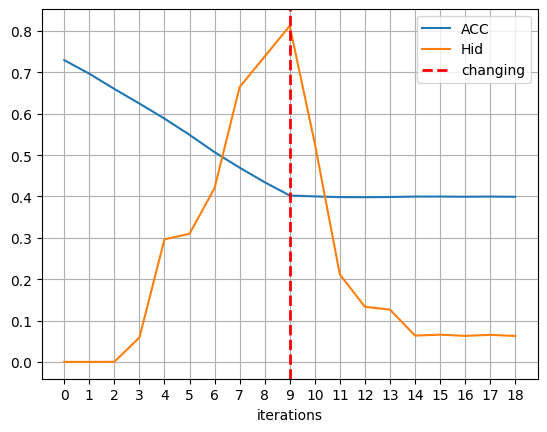

In [ ]:
df_res = pd.DataFrame(results_dict).T
df_res.columns = ['ACC', 'ROC_AUC', 'PR_AUC', 'Hid']

#df_res[['ACC', 'Hid']].plot()
plt.plot(df_res['ACC'], label='ACC')
plt.plot(df_res['Hid'], label='Hid')
plt.axvline(9, label='changing', c='red', linestyle='--', linewidth=2)
plt.legend()
plt.grid()
plt.xlabel('iterations')
plt.xticks(range(19))
plt.show()

In [ ]:
df_res.iloc[-1]

ACC          0.399242
ROC_AUC      0.394773
PR_AUC       0.447257
Hid        0.06283137
Name: 18, dtype: object

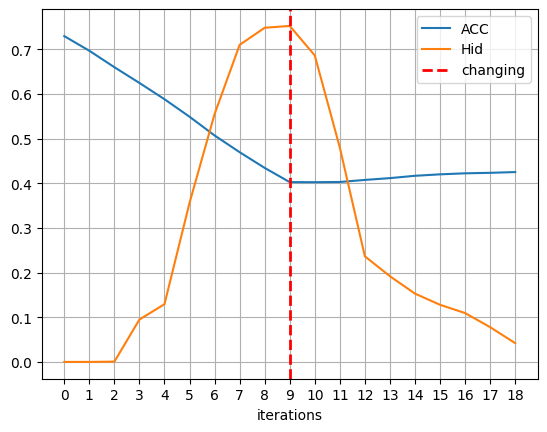

In [ ]:
df_res = pd.DataFrame(results_dict).T
df_res.columns = ['ACC', 'ROC_AUC', 'PR_AUC', 'Hid']

#df_res[['ACC', 'Hid']].plot()
plt.plot(df_res['ACC'], label='ACC')
plt.plot(df_res['Hid'], label='Hid')
plt.axvline(9, label='changing', c='red', linestyle='--', linewidth=2)
plt.legend()
plt.grid()
plt.xlabel('iterations')
plt.xticks(range(19))
plt.show()